In [104]:
!pip install sklearn
!pip install optuna
!pip install xgboost
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import numpy as np 
import optuna
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [106]:
dir = "Kaggle_Datasets"
os.listdir(dir)
cost_pred_csv = dir + "/media prediction and its cost.csv"

In [107]:
cost_df = pd.read_csv(cost_pred_csv)

#Using Sales country as stratify 
train_df, test_df = train_test_split(cost_df, train_size= 0.8, shuffle= True, stratify= cost_df['sales_country'])

In [108]:
train_df

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
262,Bread,Baked Goods,Food,7.86,3.1440,2.0,Price Slashers,USA,M,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Sunday Paper, Radio, TV",54.11
41069,Bread,Baked Goods,Food,13.84,6.6432,4.0,Price Cutters,Canada,M,F,...,16418.0,4016.0,2678.0,1.0,1.0,1.0,1.0,1.0,Cash Register Handout,122.77
12786,Decongestants,Health and Hygiene,Non-Consumable,1.62,0.7938,3.0,Sales Galore,Mexico,M,F,...,20141.0,6393.0,4262.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio",62.40
56570,Baking Goods,Baking Goods,Food,3.28,1.0824,4.0,Dimes Off,USA,M,F,...,13305.0,4746.0,3164.0,1.0,0.0,0.0,0.0,0.0,"Daily Paper, Radio",131.58
15023,Jams and Jellies,Baking Goods,Food,6.75,3.1725,3.0,Cash Register Lottery,USA,S,M,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio, TV",55.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15762,Jams and Jellies,Baking Goods,Food,7.77,2.9526,3.0,Shelf Clearing Days,USA,M,M,...,24390.0,9184.0,6122.0,0.0,0.0,1.0,1.0,0.0,Sunday Paper,106.10
35726,Bread,Baked Goods,Food,13.68,6.5664,4.0,Tip Top Savings,Mexico,M,F,...,30351.0,4819.0,3213.0,0.0,0.0,0.0,0.0,0.0,"Daily Paper, Radio",79.59
49545,Bathroom Products,Health and Hygiene,Non-Consumable,1.14,0.4104,2.0,One Day Sale,USA,M,F,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,"Daily Paper, Radio, TV",131.75
7775,Candy,Snacks,Food,5.62,2.1918,2.0,Two for One,USA,S,F,...,22063.0,4923.0,3282.0,0.0,0.0,0.0,0.0,0.0,"Daily Paper, Radio, TV",57.52


In [109]:
len(train_df.columns)

40

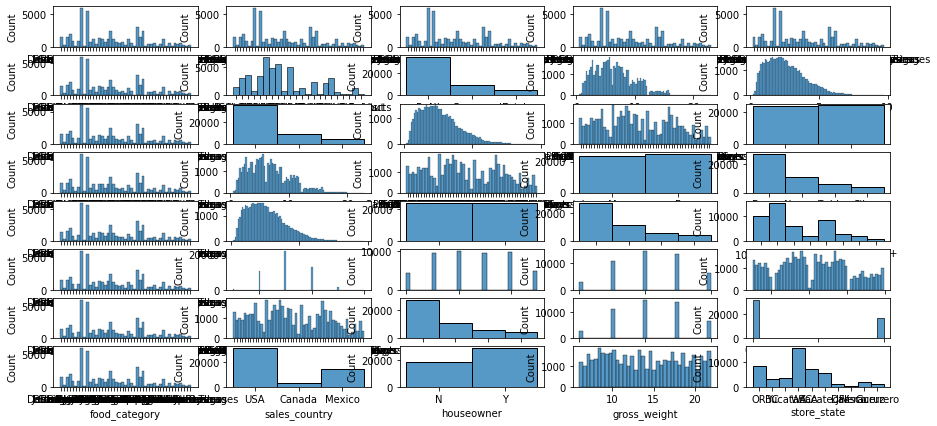

In [110]:
n_rows = 8
n_cols = 5

fig, ax = plt.subplots(n_rows,n_cols, figsize = (15,7))
for i in range(n_rows):
    for j in range(n_cols):
        sns.histplot(train_df.iloc[:,i*j], ax = ax[i, j])

In [111]:
train_df['num_children_at_home'].dtype
train_df['cost'].astype(float)

262       54.11
41069    122.77
12786     62.40
56570    131.58
15023     55.59
          ...  
15762    106.10
35726     79.59
49545    131.75
7775      57.52
15050     80.29
Name: cost, Length: 48342, dtype: float64

In [112]:
#Checking for outliers 

numeric = [a for a in train_df.columns if train_df[a].dtype == 'float64']
categoric = [a for a in train_df.columns if a not in numeric]

aesthetic = numeric[-6:]
numeric = numeric[:-6] #Excluding one-hot encoded value within dataset
numeric

['store_sales(in millions)',
 'store_cost(in millions)',
 'unit_sales(in millions)',
 'total_children',
 'avg_cars_at home(approx)',
 'num_children_at_home',
 'avg_cars_at home(approx).1',
 'SRP',
 'gross_weight',
 'net_weight',
 'recyclable_package',
 'low_fat',
 'units_per_case',
 'store_sqft',
 'grocery_sqft',
 'frozen_sqft',
 'meat_sqft']

In [113]:
categoric

['food_category',
 'food_department',
 'food_family',
 'promotion_name',
 'sales_country',
 'marital_status',
 'gender',
 'education',
 'member_card',
 'occupation',
 'houseowner',
 'avg. yearly_income',
 'brand_name',
 'store_type',
 'store_city',
 'store_state',
 'media_type']

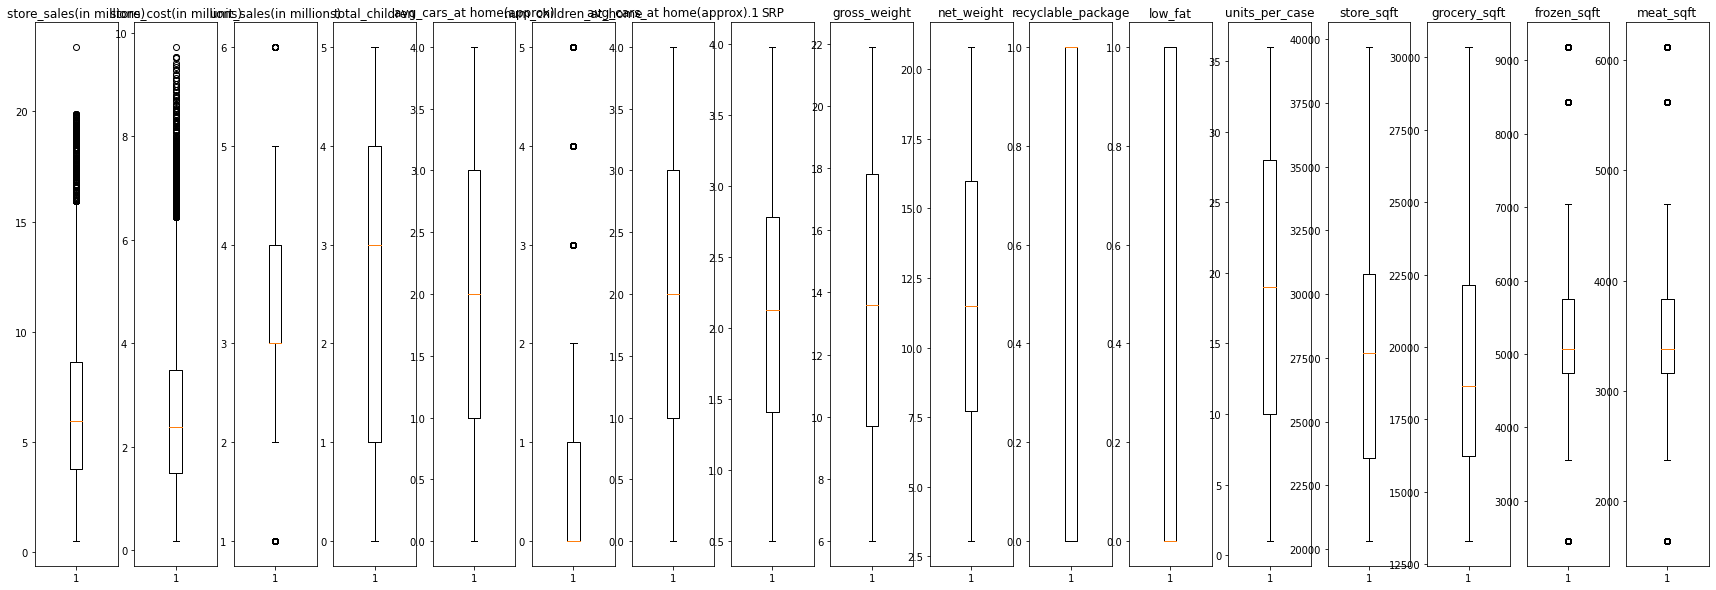

In [114]:
fig, ax = plt.subplots(1,len(numeric), figsize = (30,10))

for i,j in enumerate(numeric):
    ax[i].boxplot(train_df[j])
    ax[i].set_title(j)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f5508ad58d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5508a73e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5508a78890>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5508a81990>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5508a81ed0>],
 'means': []}

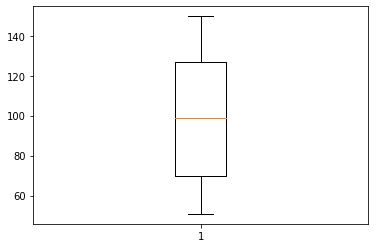

In [115]:
#Target variable
y = train_df['cost']
plt.boxplot(y)

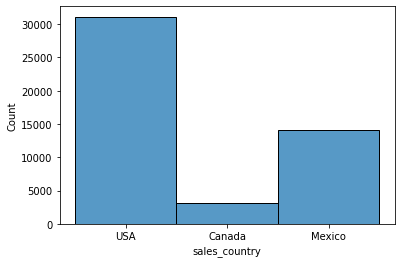

In [116]:
sns.histplot(train_df['sales_country'])

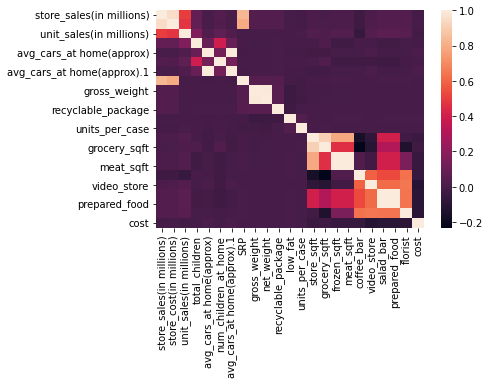

In [117]:
sns.heatmap(train_df.corr())

Assessing if aesthetics affect cost of acquiring a consumer

In [118]:
train_df.loc[:,aesthetic]

,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
262,1.0,1.0,1.0,1.0,1.0,54.11
41069,1.0,1.0,1.0,1.0,1.0,122.77
12786,1.0,1.0,1.0,1.0,1.0,62.40
56570,1.0,0.0,0.0,0.0,0.0,131.58
15023,1.0,1.0,1.0,1.0,1.0,55.59
...,...,...,...,...,...,...
15762,0.0,0.0,1.0,1.0,0.0,106.10
35726,0.0,0.0,0.0,0.0,0.0,79.59
49545,1.0,1.0,1.0,1.0,1.0,131.75
7775,0.0,0.0,0.0,0.0,0.0,57.52


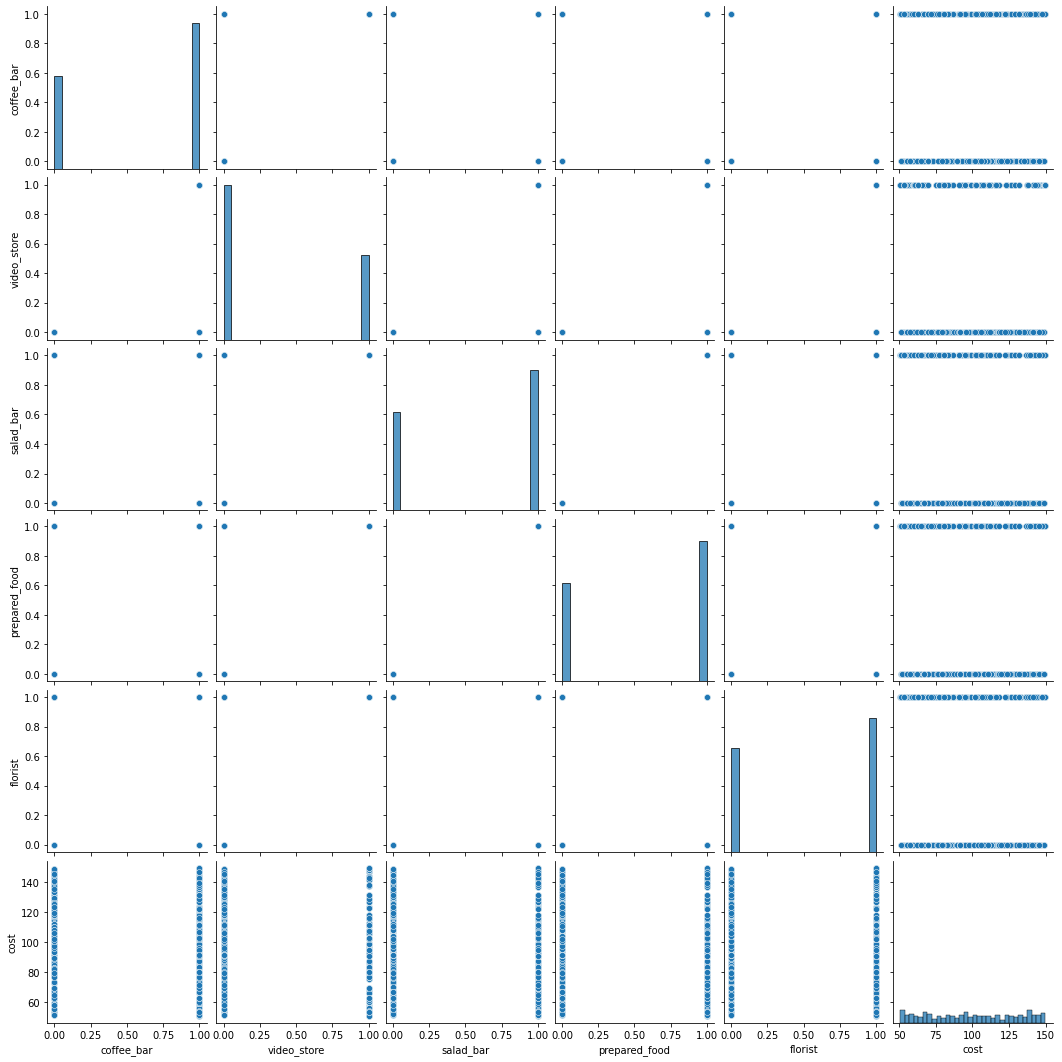

In [119]:
sns.pairplot(train_df.loc[:,aesthetic])

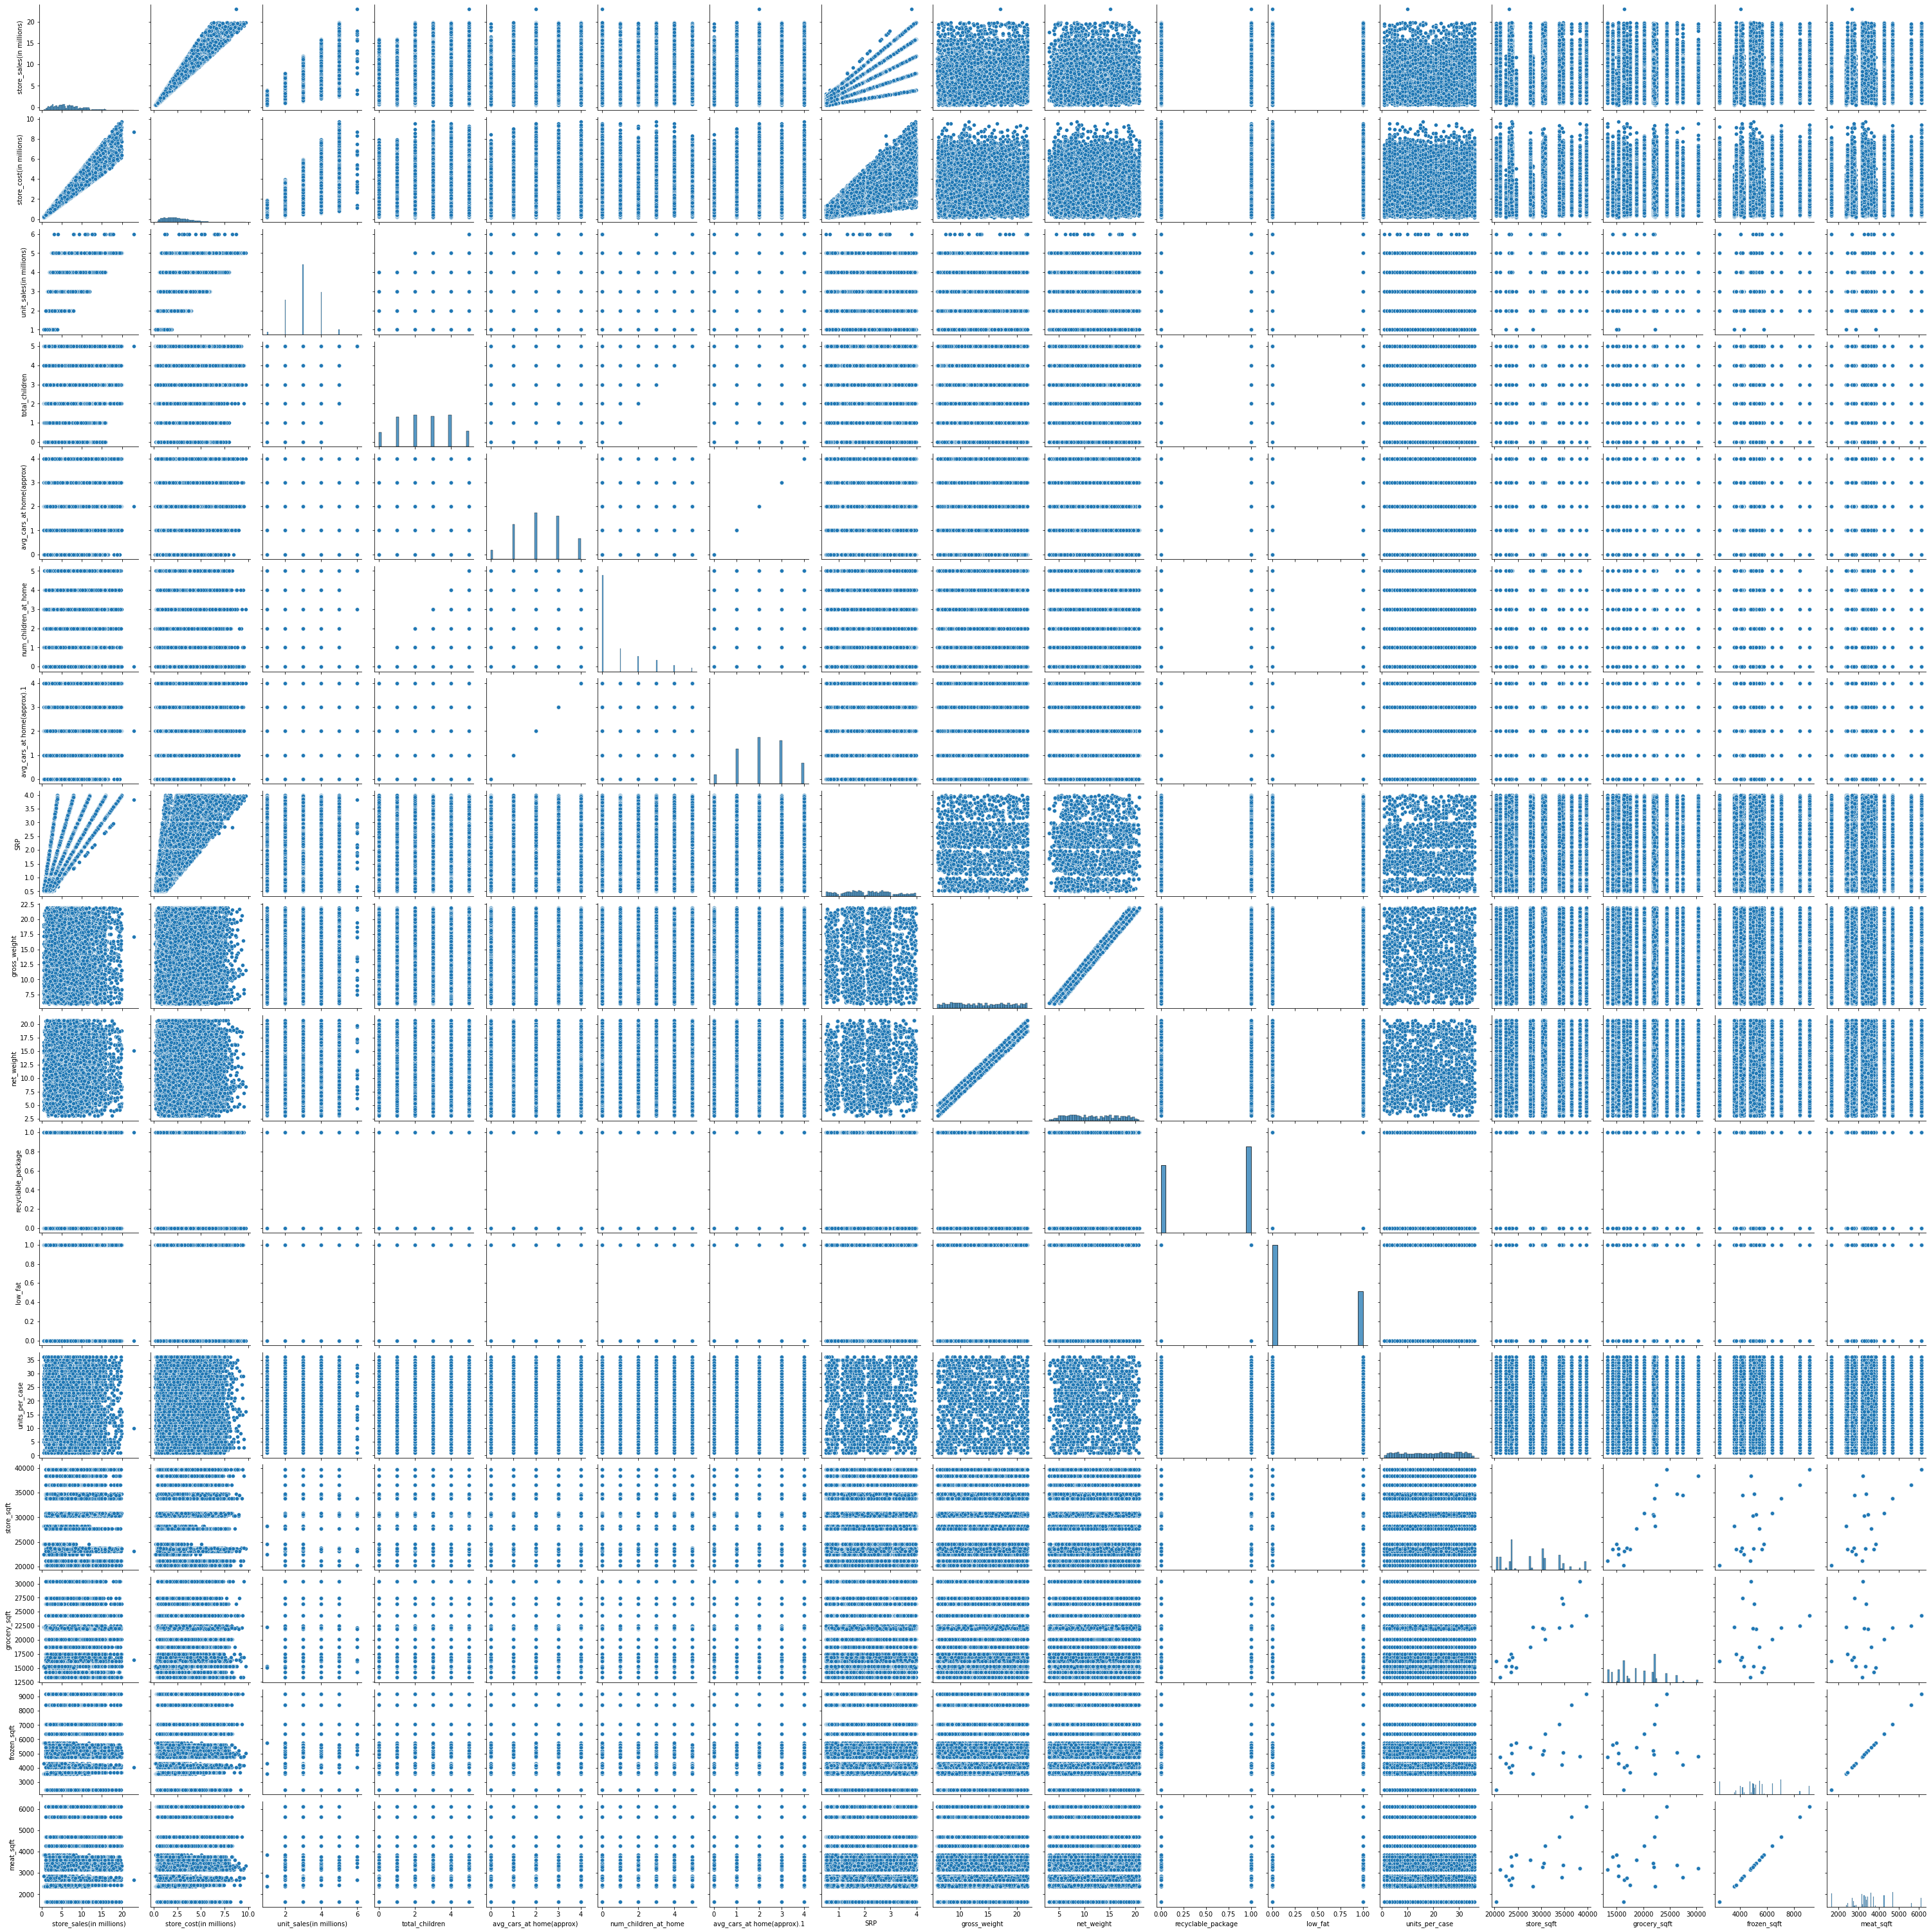

In [120]:
sns.pairplot(train_df.loc[:,numeric])

In [121]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder

#Using OneHotEncoding

f_train = pd.get_dummies(train_df.loc[:,categoric])
f_train = np.array(f_train)

f_test = pd.get_dummies(test_df.loc[:,categoric])
f_test = np.array(f_test)

#Using label Encoder
train_2 = train_df.copy()
test_2 = test_df.copy()

for a in list(train_df.loc[:,categoric]):
    le = LabelEncoder()
    train_2[a] = le.fit_transform(train_2[a])
    test_2[a] = le.fit_transform(test_2[a])


d = DictVectorizer() #Alternative to one hot encoding
d = d.fit_transform(dict(train_df.loc[:,categoric]))
d[0,:]

<1x308 sparse matrix of type '<class 'numpy.float64'>'
	with 821814 stored elements in Compressed Sparse Row format>

In [122]:
train_2

,food_category,food_department,food_family,store_sales(in millions),store_cost(in millions),unit_sales(in millions),promotion_name,sales_country,marital_status,gender,...,grocery_sqft,frozen_sqft,meat_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,media_type,cost
262,3,1,1,7.86,3.1440,2.0,27,2,0,1,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,11,54.11
41069,3,1,1,13.84,6.6432,4.0,24,0,0,0,...,16418.0,4016.0,2678.0,1.0,1.0,1.0,1.0,1.0,1,122.77
12786,18,13,2,1.62,0.7938,3.0,32,1,0,0,...,20141.0,6393.0,4262.0,1.0,1.0,1.0,1.0,1.0,3,62.40
56570,0,2,1,3.28,1.0824,4.0,8,2,0,0,...,13305.0,4746.0,3164.0,1.0,0.0,0.0,0.0,0.0,3,131.58
15023,28,2,1,6.75,3.1725,3.0,6,2,1,1,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,4,55.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15762,28,2,1,7.77,2.9526,3.0,36,2,0,1,...,24390.0,9184.0,6122.0,0.0,0.0,1.0,1.0,0.0,9,106.10
35726,3,1,1,13.68,6.5664,4.0,42,1,0,0,...,30351.0,4819.0,3213.0,0.0,0.0,0.0,0.0,0.0,3,79.59
49545,1,13,2,1.14,0.4104,2.0,22,2,0,0,...,18670.0,5415.0,3610.0,1.0,1.0,1.0,1.0,1.0,4,131.75
7775,6,20,1,5.62,2.1918,2.0,44,2,1,0,...,22063.0,4923.0,3282.0,0.0,0.0,0.0,0.0,0.0,4,57.52


In [123]:
y = np.array(train_df['cost'])
y_test = np.array(test_df['cost'])
'cost' in categoric
'cost' in numeric

False

In [124]:
ss = StandardScaler() #Standardizing numerical columns
train = ss.fit_transform(train_df.loc[:,numeric])
test = ss.fit_transform(test_df.loc[:, numeric])
print(train.shape)


#OneHotEncoding
new_train = np.concatenate((train, f_train), axis = 1)
new_test = np.concatenate((test, f_test), axis = 1)
new_train

train_2, test_2 #LabelEncoder

model = XGBRegressor()
model = model.fit(new_train, y)

(48342, 17)
[20:51:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [125]:
!pip install mlflow
import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [130]:
def xgboost_init():
    return XGBRegressor()

def objective(trial, train = train,target = y, test = new_test):

    param = {'metric':'rmse',
    'random_state': 48,
    'base_score':trial.suggest_float("base_score",0.5,0.7),
    'reg_alpha':trial.suggest_loguniform("reg_alpha",1e-3,10.0),
    'reg_lambda':trial.suggest_loguniform("reg_lambda",1e-3,10.0),
    "max_depth":trial.suggest_categorical("max_depth", [10,20,100]),
    "learning_rate":trial.suggest_categorical("learning_rate", [0.006,0.008,0.01,0.014,0.02])}

    with mlflow.start_run():
        model = XGBRegressor(**param)

        model.fit(new_train,y,verbose=False)
        
        preds = model.predict(new_test)
        rmse = mean_squared_error(y_test, preds,squared=False)

        #print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (**param))

        mlflow.log_param("param", param)
        mlflow.log_metric("rmse", rmse)

        mlflow.sklearn.log_model(model, "model")
    
    return rmse

In [127]:
y.ndim

1

In [128]:
model

XGBRegressor()

In [131]:
study = optuna.create_study(direction='minimize')
study.optimize(objective,n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-10-12 21:11:35,930] A new study created in memory with name: no-name-32f651b7-d4bb-49a5-ac27-e85965a78843
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:11:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:20:00,563] Trial 0 finished with value: 37.534299392049576 and parameters: {'base_score': 0.6597277743404626, 'reg_alpha': 0.00473975970640324, 'reg_lambda': 0.03446207080793427, 'max_depth': 100, 'learning_rate': 0.01}. Best is trial 0 with value: 37.534299392049576.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:20:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:23:37,366] Trial 1 finished with value: 48.071775936751116 and parameters: {'base_score': 0.619193543705722, 'reg_alpha': 0.054164574677041714, 'reg_lambda': 1.504899841313704, 'max_depth': 20, 'learning_rate': 0.008}. Best is trial 0 with value: 37.534299392049576.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:23:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:30:53,898] Trial 2 finished with value: 56.67440446043002 and parameters: {'base_score': 0.5746441988094332, 'reg_alpha': 0.766247770699113, 'reg_lambda': 2.4149691390619683, 'max_depth': 100, 'learning_rate': 0.006}. Best is trial 0 with value: 37.534299392049576.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:32:31,931] Trial 3 finished with value: 31.277963891752066 and parameters: {'base_score': 0.6078176347808619, 'reg_alpha': 4.578811576185656, 'reg_lambda': 0.010423103016110692, 'max_depth': 10, 'learning_rate': 0.014}. Best is trial 3 with value: 31.277963891752066.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:34:08,324] Trial 4 finished with value: 42.112007488820076 and parameters: {'base_score': 0.6623146313459016, 'reg_alpha': 0.008045328465791262, 'reg_lambda': 0.12948824878621606, 'max_depth': 10, 'learning_rate': 0.01}. Best is trial 3 with value: 31.277963891752066.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:37:39,671] Trial 5 finished with value: 17.030485756886407 and parameters: {'base_score': 0.5577731127466646, 'reg_alpha': 3.0991469391092554, 'reg_lambda': 0.2664199009609099, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:44:40,680] Trial 6 finished with value: 25.815260374643973 and parameters: {'base_score': 0.5998236054345004, 'reg_alpha': 0.006004717097339599, 'reg_lambda': 4.213074542599965, 'max_depth': 100, 'learning_rate': 0.014}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:44:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:46:17,591] Trial 7 finished with value: 22.41831905674574 and parameters: {'base_score': 0.6523982843000855, 'reg_alpha': 3.4902638220466806, 'reg_lambda': 2.565374838302003, 'max_depth': 10, 'learning_rate': 0.02}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:46:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:49:47,851] Trial 8 finished with value: 27.94732948090812 and parameters: {'base_score': 0.6058319473234933, 'reg_alpha': 0.003904465465323289, 'reg_lambda': 0.02485593866669224, 'max_depth': 20, 'learning_rate': 0.014}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:49:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:51:25,146] Trial 9 finished with value: 49.73586285005496 and parameters: {'base_score': 0.6925321420142525, 'reg_alpha': 0.15328728889700585, 'reg_lambda': 0.4681844710165405, 'max_depth': 10, 'learning_rate': 0.008}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:51:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:54:56,210] Trial 10 finished with value: 17.252305324556445 and parameters: {'base_score': 0.5035032758360755, 'reg_alpha': 0.5662054484441901, 'reg_lambda': 0.23697719161546688, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:54:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 21:58:25,994] Trial 11 finished with value: 17.197472324336726 and parameters: {'base_score': 0.5013504633127583, 'reg_alpha': 0.6901917718507236, 'reg_lambda': 0.23362502974532165, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 5 with value: 17.030485756886407.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[21:58:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:01:56,420] Trial 12 finished with value: 16.931414491287565 and parameters: {'base_score': 0.5093689073828526, 'reg_alpha': 1.4116773992482363, 'reg_lambda': 0.0018613992386426464, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:01:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:05:24,790] Trial 13 finished with value: 17.054971326403074 and parameters: {'base_score': 0.5425808224902217, 'reg_alpha': 8.219778987257436, 'reg_lambda': 0.001430850822924872, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:05:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:08:54,495] Trial 14 finished with value: 17.052678130244384 and parameters: {'base_score': 0.5402684176917919, 'reg_alpha': 2.6691100403105508, 'reg_lambda': 0.0027194912905691856, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:08:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:12:27,016] Trial 15 finished with value: 57.86986716021773 and parameters: {'base_score': 0.5437044157174675, 'reg_alpha': 0.14231133794481518, 'reg_lambda': 0.007595076058367471, 'max_depth': 20, 'learning_rate': 0.006}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:12:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:15:56,956] Trial 16 finished with value: 16.97315137666697 and parameters: {'base_score': 0.565968214588986, 'reg_alpha': 1.5126397651183696, 'reg_lambda': 0.05111929476241945, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:15:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:19:28,923] Trial 17 finished with value: 17.00815661358045 and parameters: {'base_score': 0.5205427850672899, 'reg_alpha': 0.0011323012006629646, 'reg_lambda': 0.037970815296241675, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:19:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:22:59,245] Trial 18 finished with value: 17.071555556296047 and parameters: {'base_score': 0.5769925649799932, 'reg_alpha': 0.04950411411035602, 'reg_lambda': 0.0046295252386962995, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:22:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:31:26,813] Trial 19 finished with value: 45.98134018910744 and parameters: {'base_score': 0.5196300171210535, 'reg_alpha': 0.32896317555744453, 'reg_lambda': 0.0010215696199319464, 'max_depth': 100, 'learning_rate': 0.008}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:31:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:34:58,638] Trial 20 finished with value: 39.8558565558312 and parameters: {'base_score': 0.5689930370421304, 'reg_alpha': 1.3644217680354471, 'reg_lambda': 0.020416698259545937, 'max_depth': 20, 'learning_rate': 0.01}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:34:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:38:31,832] Trial 21 finished with value: 17.038632600828446 and parameters: {'base_score': 0.5239047456440217, 'reg_alpha': 0.01826438227988447, 'reg_lambda': 0.04698522400543093, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 12 with value: 16.931414491287565.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:42:03,940] Trial 22 finished with value: 16.912339495481152 and parameters: {'base_score': 0.5219929952685426, 'reg_alpha': 0.0017153493540240034, 'reg_lambda': 0.07723425082807191, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:45:33,743] Trial 23 finished with value: 16.977558395131723 and parameters: {'base_score': 0.5326068386284825, 'reg_alpha': 0.2861810715102995, 'reg_lambda': 0.7343213737085852, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:45:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:49:04,921] Trial 24 finished with value: 17.156638892851262 and parameters: {'base_score': 0.5568624964075237, 'reg_alpha': 0.0012600548741768583, 'reg_lambda': 0.057446720956865434, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:49:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:52:42,751] Trial 25 finished with value: 57.89997282642665 and parameters: {'base_score': 0.5005241498214144, 'reg_alpha': 1.055172218618521, 'reg_lambda': 0.08445124582685856, 'max_depth': 20, 'learning_rate': 0.006}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:52:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:56:16,457] Trial 26 finished with value: 17.020631461599667 and parameters: {'base_score': 0.5925433300831427, 'reg_alpha': 8.855226308935011, 'reg_lambda': 0.014281269370237807, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 22:59:51,909] Trial 27 finished with value: 16.93133356940727 and parameters: {'base_score': 0.516418403658669, 'reg_alpha': 1.613374188502069, 'reg_lambda': 0.003565180787896105, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[22:59:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:01:28,504] Trial 28 finished with value: 22.222003563844865 and parameters: {'base_score': 0.5157805821573318, 'reg_alpha': 0.019460145198788484, 'reg_lambda': 0.002193343220517651, 'max_depth': 10, 'learning_rate': 0.02}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:01:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:08:10,633] Trial 29 finished with value: 38.75978436282868 and parameters: {'base_score': 0.5284172322716192, 'reg_alpha': 0.3305113249028296, 'reg_lambda': 8.954518344681217, 'max_depth': 100, 'learning_rate': 0.01}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:08:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:16:42,434] Trial 30 finished with value: 25.09089316756528 and parameters: {'base_score': 0.5117906622856974, 'reg_alpha': 0.002368089638757175, 'reg_lambda': 0.004222684032327964, 'max_depth': 100, 'learning_rate': 0.014}. Best is trial 22 with value: 16.912339495481152.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:16:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:20:13,884] Trial 31 finished with value: 16.78963582100294 and parameters: {'base_score': 0.5530285582495036, 'reg_alpha': 1.7970102155455148, 'reg_lambda': 0.00503425608153845, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:20:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:23:50,373] Trial 32 finished with value: 17.024016797915234 and parameters: {'base_score': 0.5369611923487867, 'reg_alpha': 2.0146721061168957, 'reg_lambda': 0.0060000831885295815, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:23:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:27:27,291] Trial 33 finished with value: 48.03954793153872 and parameters: {'base_score': 0.5544392814994084, 'reg_alpha': 0.07304179175970316, 'reg_lambda': 0.002761883312135206, 'max_depth': 20, 'learning_rate': 0.008}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:27:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:31:02,941] Trial 34 finished with value: 57.88750053754923 and parameters: {'base_score': 0.5104771850146994, 'reg_alpha': 0.5116577269000953, 'reg_lambda': 0.0017325731693026264, 'max_depth': 20, 'learning_rate': 0.006}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:34:36,541] Trial 35 finished with value: 16.88033730199862 and parameters: {'base_score': 0.5494759308766222, 'reg_alpha': 5.1675975236691585, 'reg_lambda': 0.01054948321257754, 'max_depth': 20, 'learning_rate': 0.02}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:34:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:38:11,811] Trial 36 finished with value: 39.836932909492496 and parameters: {'base_score': 0.6239784718331551, 'reg_alpha': 5.926810733558892, 'reg_lambda': 0.011700607312274422, 'max_depth': 20, 'learning_rate': 0.01}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:39:49,784] Trial 37 finished with value: 22.0713139671268 and parameters: {'base_score': 0.5822817246281292, 'reg_alpha': 5.4441004679455025, 'reg_lambda': 0.016738290862252855, 'max_depth': 10, 'learning_rate': 0.02}. Best is trial 31 with value: 16.78963582100294.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:39:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:48:08,568] Trial 38 finished with value: 13.717873358685095 and parameters: {'base_score': 0.550346116549268, 'reg_alpha': 2.36703060413738, 'reg_lambda': 0.007210033089074361, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 38 with value: 13.717873358685095.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:48:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-12 23:56:30,991] Trial 39 finished with value: 45.9636742058487 and parameters: {'base_score': 0.5519345267702798, 'reg_alpha': 2.745542551634491, 'reg_lambda': 0.009119552772159532, 'max_depth': 100, 'learning_rate': 0.008}. Best is trial 38 with value: 13.717873358685095.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[23:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:04:51,792] Trial 40 finished with value: 25.10573012917456 and parameters: {'base_score': 0.5869643877265425, 'reg_alpha': 3.7494626242426468, 'reg_lambda': 0.10697324606226498, 'max_depth': 100, 'learning_rate': 0.014}. Best is trial 38 with value: 13.717873358685095.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:04:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:13:07,021] Trial 41 finished with value: 13.69032140942517 and parameters: {'base_score': 0.5482550064939614, 'reg_alpha': 5.014239885785365, 'reg_lambda': 0.005517463825896728, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 41 with value: 13.69032140942517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:13:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:21:34,288] Trial 42 finished with value: 13.694676223802462 and parameters: {'base_score': 0.5622548411232455, 'reg_alpha': 4.563520323177143, 'reg_lambda': 0.025590340619640307, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 41 with value: 13.69032140942517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:21:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:29:45,039] Trial 43 finished with value: 13.706492234750973 and parameters: {'base_score': 0.5654979300942744, 'reg_alpha': 6.25502418247045, 'reg_lambda': 0.023873675202003876, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 41 with value: 13.69032140942517.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:37:48,479] Trial 44 finished with value: 13.689789087045067 and parameters: {'base_score': 0.5647129827411833, 'reg_alpha': 8.944017500294132, 'reg_lambda': 0.005737087392947543, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 44 with value: 13.689789087045067.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:45:48,569] Trial 45 finished with value: 13.696991982333632 and parameters: {'base_score': 0.5661893759887318, 'reg_alpha': 9.071568443159366, 'reg_lambda': 0.025197152315896722, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 44 with value: 13.689789087045067.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:45:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 00:53:56,242] Trial 46 finished with value: 13.773597020976034 and parameters: {'base_score': 0.5671045266200733, 'reg_alpha': 9.731628391976466, 'reg_lambda': 0.03257281310252403, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 44 with value: 13.689789087045067.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[00:53:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 01:02:15,014] Trial 47 finished with value: 56.2151603094823 and parameters: {'base_score': 0.6278228787378942, 'reg_alpha': 6.5686219036552815, 'reg_lambda': 0.023473094643838965, 'max_depth': 100, 'learning_rate': 0.006}. Best is trial 44 with value: 13.689789087045067.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[01:02:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 01:10:37,988] Trial 48 finished with value: 25.071517733872373 and parameters: {'base_score': 0.5933280747646057, 'reg_alpha': 3.9524591407519964, 'reg_lambda': 0.028331292244447217, 'max_depth': 100, 'learning_rate': 0.014}. Best is trial 44 with value: 13.689789087045067.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove the CWD from sys.path while we load stuff.


[01:10:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2022-10-13 01:18:49,995] Trial 49 finished with value: 13.776195114677646 and parameters: {'base_score': 0.5632688171128469, 'reg_alpha': 9.983360977003718, 'reg_lambda': 0.015488922618038548, 'max_depth': 100, 'learning_rate': 0.02}. Best is trial 44 with value: 13.689789087045067.


Number of finished trials: 50
Best trial: {'base_score': 0.5647129827411833, 'reg_alpha': 8.944017500294132, 'reg_lambda': 0.005737087392947543, 'max_depth': 100, 'learning_rate': 0.02}


In [139]:
best_model = XGBRegressor(**study.best_trial.params)

best_model.fit(new_train,y)
preds = best_model.predict(new_test)

rmse = mean_squared_error(y_test, preds,squared=False)
rmse

[05:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


13.689789087045067

In [ ]:
#hypeparameter tuning with optuna
#weight adjustment
#Create pipeline

array([136.95581 ,  53.430042, 124.564445, ..., 136.69673 , 119.066956,
        80.9135  ], dtype=float32)

In [ ]:
pred = model.predict(new_train)
mean_squared_error(y, pred)

4.251169703974441